<a href="https://colab.research.google.com/github/pethodoma/BME-DeepLearning-BirdCLEF_2023/blob/main/Custom_datagenerator_augmentation_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import librosa
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import audiomentations

In [ ]:
!wget -q -O training_files.zip https://www.dropbox.com/scl/fi/xefxidhnea3t6l5pkq6he/atleast_500.zip?rlkey=qe01cuxklk6ge1irpqarq7eoq&dl=0
!wget -q -O atleast_500.csv https://www.dropbox.com/scl/fi/tvoxpxnsolwv58fouk51o/atleast_500.csv?rlkey=m8uhqea3mysnpnjtc0aptkl93&dl=0

In [ ]:
!unzip -q 'training_files.zip'

In [ ]:
def read_file_paths(main_directory):
    main_directory = main_directory
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.ogg'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

In [ ]:
# Creating the dict with the numerical categoris to each filepath
filepaths = read_file_paths(os.getcwd())
df = pd.read_csv('atleast_500.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df['Category'] = range(len(df))
labels = {filename: df[df['Bird'] == filename.split(os.path.sep)[-2]]['Category'].values[0] for filename in filepaths}

In [ ]:
train_paths, test_paths = train_test_split(filepaths, test_size=0.1, random_state=42)
partition = {'train': train_paths, 'test': test_paths}

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128, 313), n_channels=1,
                 n_classes=30, shuffle=True, augmentation_prob=0.5):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation_prob = augmentation_prob
        self.augmenter = audiomentations.Compose([audiomentations.AddGaussianNoise(),audiomentations.TimeStretch(), audiomentations.PitchShift()])
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            audio, sr = librosa.load(ID, sr=None)

            if np.random.rand() < self.augmentation_prob:
                audio = self.augmenter(samples=audio, sample_rate=sr)

            spec = librosa.feature.melspectrogram(y=audio, sr=sr)
            spec_db = librosa.power_to_db(spec, ref=np.max)
            spec_normalized = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
            X[i,] = spec_normalized.reshape((*self.dim, self.n_channels))

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
tg = DataGenerator(partition['train'], labels, batch_size=1)
x, y = tg._DataGenerator__data_generation(partition['train'][:1])
x.shape

(1, 128, 313, 1)

In [ ]:
training_generator = DataGenerator(partition['train'], labels, batch_size=64)
validation_generator = DataGenerator(partition['test'], labels, batch_size=64)

In [ ]:
es = keras.callbacks.EarlyStopping(patience=2, monitor='val_loss', verbose=1)
mc = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=1)

In [ ]:
num_classes = 30
imported_model= keras.applications.ResNet50(include_top=False, input_shape=(128,313,3),
                                                     pooling='avg', weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(3,(1,1),padding='same', input_shape=(128,313,1)))
model.add(imported_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(num_classes, activation='softmax'))
model.build((None, 128, 313, 1))
model.compile('Adam', loss='CategoricalCrossentropy', metrics=['accuracy', 'categorical_crossentropy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 313, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 30)                15390     
                                                                 
Total params: 24652196 (94.04 MB)
Trainable params: 1064484 (4.06 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
num_epochs = 5

history = model.fit(x=training_generator,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    callbacks=[es, mc],
                    workers=6,  # Adjust the number of workers based on your system capabilities
                    use_multiprocessing=True)

model.save('final_model.h5')

Epoch 1/5
667/667 [==============================] - ETA: 0s - loss: 2.9988 - accuracy: 0.2026 - categorical_crossentropy: 2.9988 - precision: 0.6712 - recall: 0.0210
Epoch 1: val_loss improved from inf to 2.75437, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


667/667 [==============================] - 2409s 4s/step - loss: 2.9988 - accuracy: 0.2026 - categorical_crossentropy: 2.9988 - precision: 0.6712 - recall: 0.0210 - val_loss: 2.7544 - val_accuracy: 0.2521 - val_categorical_crossentropy: 2.7544 - val_precision: 0.7628 - val_recall: 0.0598
Epoch 2/5
667/667 [==============================] - ETA: 0s - loss: 2.4318 - accuracy: 0.3269 - categorical_crossentropy: 2.4318 - precision: 0.7629 - recall: 0.1126
Epoch 2: val_loss improved from 2.75437 to 2.12761, saving model to best_model.h5
667/667 [==============================] - 2388s 4s/step - loss: 2.4318 - accuracy: 0.3269 - categorical_crossentropy: 2.4318 - precision: 0.7629 - recall: 0.1126 - val_loss: 2.1276 - val_accuracy: 0.4008 - val_categorical_crossentropy: 2.1276 - val_precision: 0.8268 - val_recall: 0.1744
Epoch 3/5
667/667 [==============================] - ETA: 0s - loss: 2.0088 - accuracy: 0.4330 - categorical_crossentropy: 2.0088 - precision: 0.8218 - recall: 0.2093
Epoch 

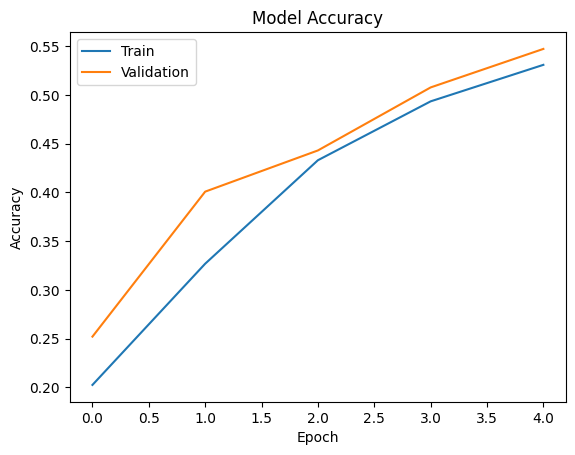

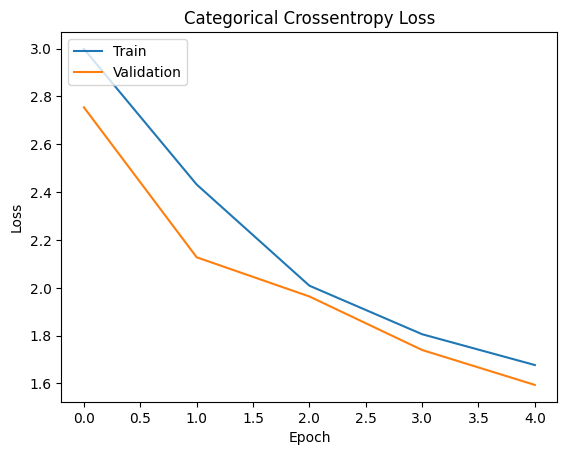

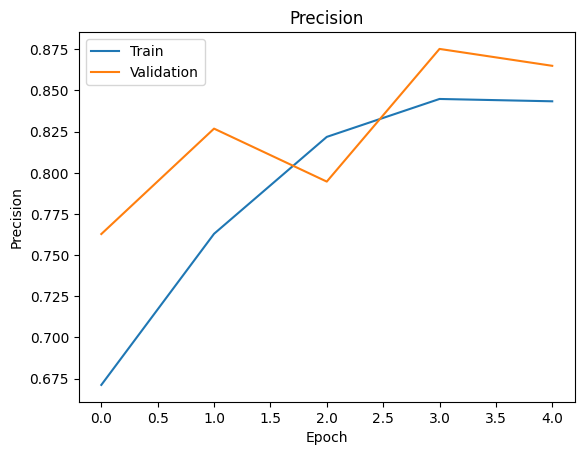

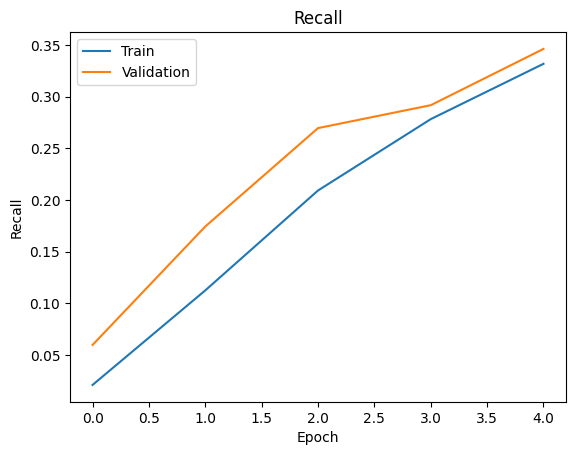

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import random

def simpleevaluation(eval_set, iterations, model, df):
    predictions = {}
    for i in range(iterations):
        current_sample = eval_set[random.randint(0, len(eval_set))]
        y, sr = librosa.load(current_sample, sr=None)
        spec = librosa.feature.melspectrogram(y=y, sr=sr)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_normalized = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
        final_spec = np.array([spec_normalized.reshape((128, 313, 1))])

        prediction = model.predict(final_spec)
        prediction_index = np.where(prediction == np.max(prediction))[1][0]
        prediction_label = df[df['Category'] == prediction_index]['Bird'].values[0]
        actual_label = current_sample.split(os.path.sep)[-2]
        predictions[i] = {'predicted label': prediction_label,
                          'probability': np.max(prediction),
                          'actual label': actual_label}
    return predictions


In [ ]:
eval = simpleevaluation(partition['test'], 5, model, df)
for key, value in eval.items():
    print(f'Predicted bird: {value["predicted label"]} with likeliness of {value["probability"]}, actual bird: {value["actual label"]}')

1/1 [==============================] - 0s 40ms/step
Predicted bird: hoopoe with likeliness of 0.9811935424804688, actual bird: hoopoe
Predicted bird: eubeat1 with likeliness of 0.7021338939666748, actual bird: eubeat1
Predicted bird: cohmar1 with likeliness of 0.6439434885978699, actual bird: cohmar1
Predicted bird: cohmar1 with likeliness of 0.5899724960327148, actual bird: woosan
Predicted bird: thrnig1 with likeliness of 0.20339994132518768, actual bird: combul2
